## Import Libraries

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_style('whitegrid')

In [2]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline, make_union

In [3]:
from imblearn.over_sampling import SMOTE

## Load Datasets

In [4]:
test_df = pd.read_csv('data/data_test.csv', index_col='id')
print('Shape of Test Dataset = ', test_df.shape) # ~ 9L rows with 56 cols
test_df.head()

Shape of Test Dataset =  (892816, 56)


num1  num2  num3  num4  num5  num6  num7  num8  num9  num10  ...    cat5  \
id                                                               ...           
0      0     8     0     1     0     0     0     0     0      0  ...     1.0   
1      4     5     0     0     0     1     0     0     0      0  ...     1.0   
2      5     3     0     0     0     1     0     0     0      0  ...     1.0   
3      0     6     1     0     0     0     0     0     0      0  ...     1.0   
4      5     7     0     0     0     1     0     0     0      0  ...     1.0   

    cat6  cat7  cat8  cat9  cat10  cat11  cat12  cat13  cat14  
id                                                             
0    NaN     0   NaN     1    1.0      1    2.0      1     65  
1    NaN     0   0.0    11    1.0      1    0.0      1    103  
2    NaN     0   NaN    14    1.0      1    2.0      1     29  
3    NaN     0   NaN     1    1.0      1    2.0      1     40  
4    NaN     0   NaN    11    1.0      1    2.0      1    101  

[5 rows x 56 columns]

In [5]:
train_df = pd.read_csv('data/data_train.csv', index_col='id')
print('Shape of Train Dataset = ', train_df.shape) # ~ 6L rows with 57 cols (incl. the Target col.)
train_df.head()

Shape of Train Dataset =  (596000, 57)


num1  num2  num3  num4  num5  num6  num7  num8  num9  num10   ...    cat6  \
id                                                                ...           
0      2     5     0     1     0     0     0     0     0      0   ...     NaN   
1      1     7     0     0     1     0     0     0     0      0   ...     NaN   
2      5     9     0     0     1     0     0     0     0      0   ...     NaN   
3      0     2     1     0     0     0     0     0     0      0   ...     0.0   
4      0     0     1     0     0     0     0     0     0      0   ...     NaN   

    cat7  cat8  cat9  cat10  cat11  cat12  cat13  cat14  target  
id                                                               
0      0   1.0     4    1.0      0    0.0      1     12       0  
1      0   NaN    11    1.0      1    2.0      1     19       0  
2      0   NaN    14    1.0      1    2.0      1     60       0  
3      0   1.0    11    1.0      1    3.0      1    104       0  
4      0   NaN    14    1.0      1    2.0      1     82       0  

[5 rows x 57 columns]

## EDA

#### Check for data imbalance

In [6]:
# Imbalanced data-distribution?
train_df.target.value_counts()

0    574284
1     21716
Name: target, dtype: int64

In [7]:
count_total = train_df.shape[0]
count_0 = train_df.loc[train_df['target'] == 0].shape[0]
count_1 = train_df.loc[train_df['target'] == 1].shape[0]
perc_0 = (count_0 / count_total) * 100
perc_1 = (count_1 / count_total) * 100

print('perc_0 = ', round(perc_0, 2))
print('perc_1 = ', round(perc_1, 2))

perc_0 =  96.36
perc_1 =  3.64


#### Check for columns having NaN values in datasets and Fill it up

In [8]:
res = test_df.isnull().sum()
test_nan_cols = res[res>0]
print('test_nan_cols = ', test_nan_cols.index.values)
print(test_nan_cols.sort_values(ascending=False))

test_nan_cols =  ['num18' 'num19' 'num22' 'cat1' 'cat2' 'cat3' 'cat4' 'cat5' 'cat6' 'cat8'
 'cat10' 'cat12']
cat6     616911
cat8     400359
num18    161684
num22     63805
cat10     17331
cat3       8710
cat12       877
cat1        307
cat4        160
cat2        145
cat5          5
num19         1
dtype: int64


In [11]:
res = train_df.isnull().sum()
train_nan_cols = res[res>0]
print('train_nan_cols = ', train_nan_cols.index.values)
print(train_nan_cols.sort_values(ascending=False))

train_nan_cols =  ['num18' 'num19' 'num20' 'num22' 'cat1' 'cat2' 'cat3' 'cat4' 'cat5' 'cat6'
 'cat8' 'cat10' 'cat12']
cat6     411792
cat8     266928
num18    107909
num22     42667
cat10     11503
cat3       5814
cat12       570
cat1        217
cat4        107
cat2         83
cat5          5
num19         5
num20         1
dtype: int64


In [12]:
cat_cols = []
for i in range(1,15):
    cat_cols.append("cat{}".format(i))
print(cat_cols)

['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14']


In [13]:
other_cols = [col for col in train_df.columns if col not in cat_cols]
other_cols.remove('target')
print(other_cols)

['num1', 'num2', 'num3', 'num4', 'num5', 'num6', 'num7', 'num8', 'num9', 'num10', 'num11', 'num12', 'num13', 'num14', 'num15', 'num16', 'num17', 'num18', 'num19', 'num20', 'num21', 'num22', 'num23', 'der1', 'der2', 'der3', 'der4', 'der5', 'der6', 'der7', 'der8', 'der9', 'der10', 'der11', 'der12', 'der13', 'der14', 'der15', 'der16', 'der17', 'der18', 'der19', 'target']


In [32]:
cols_almost_empty = ['cat6', 'cat8']
def create_was_missing_column_for(df, cols):
    for col in cols:
        new_col = "{}_was_missing".format(col)
        df[new_col] = df[col].isna()
        df[new_col] = df[new_col].astype(np.int8) # Converts bool to int
#         print(df[new_col].value_counts())

In [34]:
create_was_missing_column_for(train_df,cols_almost_empty)
create_was_missing_column_for(test_df,cols_almost_empty)

In [35]:
# First do explicit fillna for cols with large missing values
# Caution: Order of finn_na is important here and it is to be done based on train_df only!
def fillna_df(df):
    df[cols_almost_empty] = df[cols_almost_empty].fillna(999) # No negative number! 
    df[cat_cols] = df[cat_cols].fillna(train_df[cat_cols].mode().iloc[0])
    df[other_cols] = df[other_cols].fillna(train_df[other_cols].mode().iloc[0])

In [36]:
# train_df[cols_almost_empty] = train_df[cols_almost_empty].fillna(999) # No negative number! 
# train_df[cat_cols] = train_df[cat_cols].fillna(train_df[cat_cols].mode().iloc[0])
# train_df[other_cols] = train_df[other_cols].fillna(train_df[other_cols].mode().iloc[0])

fillna_df(train_df)
train_df.head()

num1  num2  num3  num4  num5  num6  num7  num8  num9  num10  \
id                                                                
0      2     5     0     1     0     0     0     0     0      0   
1      1     7     0     0     1     0     0     0     0      0   
2      5     9     0     0     1     0     0     0     0      0   
3      0     2     1     0     0     0     0     0     0      0   
4      0     0     1     0     0     0     0     0     0      0   

          ...         cat8  cat9  cat10  cat11  cat12  cat13  cat14  target  \
id        ...                                                                 
0         ...            1     4      1      0      0      1     12       0   
1         ...          999    11      1      1      2      1     19       0   
2         ...          999    14      1      1      2      1     60       0   
3         ...            1    11      1      1      3      1    104       0   
4         ...          999    14      1      1      2      1     82       0   

    cat6_was_missing  cat8_was_missing  
id                                      
0                  0                 0  
1                  0                 0  
2                  0                 0  
3                  0                 0  
4                  0                 0  

[5 rows x 59 columns]

In [37]:
fillna_df(test_df)
test_df.head()

num1  num2  num3  num4  num5  num6  num7  num8  num9  num10  \
id                                                                
0      0     8     0     1     0     0     0     0     0      0   
1      4     5     0     0     0     1     0     0     0      0   
2      5     3     0     0     0     1     0     0     0      0   
3      0     6     1     0     0     0     0     0     0      0   
4      5     7     0     0     0     1     0     0     0      0   

          ...         cat7   cat8  cat9  cat10  cat11  cat12  cat13  cat14  \
id        ...                                                                
0         ...            0  999.0     1    1.0      1    2.0      1     65   
1         ...            0    0.0    11    1.0      1    0.0      1    103   
2         ...            0  999.0    14    1.0      1    2.0      1     29   
3         ...            0  999.0     1    1.0      1    2.0      1     40   
4         ...            0  999.0    11    1.0      1    2.0      1    101   

    cat6_was_missing  cat8_was_missing  
id                                      
0                  0                 0  
1                  0                 0  
2                  0                 0  
3                  0                 0  
4                  0                 0  

[5 rows x 58 columns]

In [38]:
for col in cat_cols:
    train_df[col] = train_df[col].astype(np.int16).astype('category')
    test_df[col] = test_df[col].astype(np.int16).astype('category')

In [39]:
train_df['cat6_was_missing'] = train_df['cat6_was_missing'].astype('category')
train_df['cat8_was_missing'] = train_df['cat8_was_missing'].astype('category')

test_df['cat6_was_missing'] = test_df['cat6_was_missing'].astype('category')
test_df['cat8_was_missing'] = test_df['cat8_was_missing'].astype('category')

#### Find correlation between features and with the target

In [40]:
corr = train_df.corr()

In [41]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, 
            cmap=sns.diverging_palette(250, 10, as_cmap=True),
            ax=ax, 
            square=True)

# derived columns bears no correlation whatsoever with any. Noise??
# col num11 seem to be strongly correlated with col num9 and well correlated with col num8
# col num4 seem to be strongly inversely-correlated with col num3

In [42]:
der_cols = list( map(lambda x: "der{}".format(x), range(1,20)) )
non_der_cols = [x for x in train_df.columns if x not in der_cols]
non_der_cols.remove('target')
print(non_der_cols)

['num1', 'num2', 'num3', 'num4', 'num5', 'num6', 'num7', 'num8', 'num9', 'num10', 'num11', 'num12', 'num13', 'num14', 'num15', 'num16', 'num17', 'num18', 'num19', 'num20', 'num21', 'num22', 'num23', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat6_was_missing', 'cat8_was_missing']


In [43]:
y = train_df.pop('target')
x = train_df[non_der_cols]
print('Shape of x:',x.shape, ', and y:', y.shape)

Shape of x: (596000, 39) , and y: (596000,)


## Modelling

In [44]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.70, random_state = 42)

count_total = x_train.shape[0]
count_0 = x_train[y_train==0].shape[0]
count_0_pc = (count_0/count_total)*100
count_1 = x_train[y_train==1].shape[0]
count_1_pc = (count_1/count_total)*100
print('x_train')
print('Total Count = ', count_total)
print('Count of 0 targets = ', count_0, ' which is {}% of total count'.format(round(count_0_pc, 2)))
print('Count of 1 targets = ', count_1, ' which is {}% of total count'.format(round(count_1_pc, 2)))

count_total = x_test.shape[0]
count_0 = x_test[y_test==0].shape[0]
count_0_pc = (count_0/count_total)*100
count_1 = x_test[y_test==1].shape[0]
count_1_pc = (count_1/count_total)*100
print('x_test')
print('Total Count = ', count_total)
print('Count of 0 targets = ', count_0, ' which is {}% of total count'.format(round(count_0_pc, 2)))
print('Count of 1 targets = ', count_1, ' which is {}% of total count'.format(round(count_1_pc, 2)))

C:\Anaconda3\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


x_train
Total Count =  417200
Count of 0 targets =  402099  which is 96.38% of total count
Count of 1 targets =  15101  which is 3.62% of total count
x_test
Total Count =  178800
Count of 0 targets =  172185  which is 96.3% of total count
Count of 1 targets =  6615  which is 3.7% of total count


In [45]:

DESC = 'desc'
TRAIN_ACC_SCORE = 'train_acc_score'
TRAIN_F1_SCORE = 'train_f1_score'
TRAIN_PREC_SCORE = 'train_prec_score'
TRAIN_REC_SCORE = 'train_rec_score'
VALID_ACC_SCORE = 'valid_acc_score'
VALID_F1_SCORE = 'valid_f1_score'
VALID_PREC_SCORE = 'valid_prec_score'
VALID_REC_SCORE = 'valid_rec_score'
VALID_ROC_AUC = 'valid_roc_auc'

def fit_score(classifier, xtrain, ytrain, xtest, ytest, verbose=True, score_metric='weighted'):
    desc = 'Classifier : {0}'.format(classifier.__class__.__name__)
    print('Processing with {}'.format(desc))
    classifier.fit(xtrain, ytrain)
    training_acc_score = classifier.score(xtrain, ytrain)
    validation_acc_score = classifier.score(xtest, ytest)
    ytrain_pred = classifier.predict(xtrain)
    ytest_pred = classifier.predict(xtest)
    training_f1_score = f1_score(ytrain, ytrain_pred, average=score_metric)
    training_precision_score = precision_score(ytrain, ytrain_pred, average=score_metric)
    training_recall_score = recall_score(ytrain, ytrain_pred, average=score_metric)
    validation_f1_score = f1_score(ytest, ytest_pred, average=score_metric)
    validation_precision_score = precision_score(ytest, ytest_pred, average=score_metric)
    validation_recall_score = recall_score(ytest, ytest_pred, average=score_metric)
    creport = classification_report(y_test, ytest_pred, target_names=['Zero', 'One'])
    print("Classification Report for Validation Data:")
    print(creport)
    y_pred_probas = classifier.predict_proba(x_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probas)
    validation_roc_auc = auc(fpr,tpr)    
    return {
        DESC: desc, 
        TRAIN_ACC_SCORE: training_acc_score, 
        TRAIN_F1_SCORE: training_f1_score,
        TRAIN_PREC_SCORE: training_precision_score,
        TRAIN_REC_SCORE: training_recall_score,
        VALID_ACC_SCORE: validation_acc_score,         
        VALID_F1_SCORE: validation_f1_score,
        VALID_PREC_SCORE: validation_precision_score,
        VALID_REC_SCORE: validation_recall_score,
        VALID_ROC_AUC: validation_roc_auc
    }

### LGBMClassifier with scaled data

In [46]:
numeric_cols = [x for x in x_train.columns if x.startswith('num')]
cat_cols = [x for x in x_train.columns if x.startswith('cat')]
preprocess = make_column_transformer(
    (numeric_cols, RobustScaler()),
    (cat_cols, OneHotEncoder()),
)
lgbm_clf = LGBMClassifier(random_state=42, verbose=2, class_weight='balanced')
clf = make_pipeline(preprocess, lgbm_clf)
clf

Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True), ['num1', 'num2', 'num3',...        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0, verbose=2))])

Processing with Classifier : Pipeline


C:\Anaconda3\envs\py36\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Classification Report for Validation Data:
              precision    recall  f1-score   support

        Zero       0.97      0.65      0.78    172185
         One       0.06      0.54      0.10      6615

   micro avg       0.65      0.65      0.65    178800
   macro avg       0.52      0.60      0.44    178800
weighted avg       0.94      0.65      0.76    178800

{'desc': 'Classifier : Pipeline', 'train_acc_score': 0.6539477468839885, 'train_f1_score': 0.11835974474061861, 'train_prec_score': 0.06519165310048838, 'train_rec_score': 0.6417455797629296, 'valid_acc_score': 0.646907158836689, 'valid_f1_score': 0.10234462754688542, 'valid_prec_score': 0.056485027308682274, 'valid_rec_score': 0.5440665154950869, 'valid_roc_auc': 0.6386867967140846}
[[112068  60117]
 [  3016   3599]]


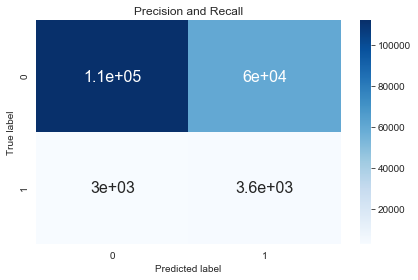

In [47]:
score = fit_score(clf, x_train, y_train, x_test, y_test, score_metric='binary')
print(score)

y_preds = clf.predict(x_test)
conf_matrix = confusion_matrix(y_test, y_preds)
print(conf_matrix)
fig, ax = plt.subplots()
sns.heatmap(conf_matrix,            
            annot=True, 
            annot_kws={"size": 16}, 
            ax=ax,
            cmap=plt.cm.Blues)
ax.set_title("Precision and Recall")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

## Make Predictions on Test Dataset

In [48]:
def conv2df(ids,preds):
    df = pd.DataFrame(data={
        'id': ids,
        'target': preds
    })
    df['target'] = df['target'].astype(np.int8)
    return df

In [49]:
test_df_y_preds = clf.predict(test_df)

In [50]:
conv2df(test_df.index.values,test_df_y_preds).to_csv('data/output/final.csv', index=False)